# Классификация комментариев на позитивные и негативные

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Оглавление<a class='anchor' id='TOC'>
***

* **[1. Подготовка](#1)**
    - [1) Объявим класс DataExplorer и наполним его методами](#1_1)
    - [2) Импортируем библиотеки](#1_2)
    - [3) Прочитаем данные в переменную](#1_3)
    - [4) Выведем первые, последние и случайные пять строк](#1_4)
    - [5) Выведем общую информацию о датасете, общую статистику, проверим соотношение классов](#1_5)
    - [6) Подготовим датасет к обучению, создадим признаки: очистим текст от шумовых знаков, применим стемминг, результат сохраним в новой колонке](#1_6)   
    - [7) Разделим выборку на обучающую и тестовую в соотношении 80:20, векторизирует тексты, выделим целевой признак](#1_7) 
    - [8) Cоздадим словарь для поиска наилучших параметров модели, инициализируем модели, выберем параметры для подбора](#1_8)     
    - [Вывод](#1_conclusion)
    
    
* **[2. Обучение](#2)**
    - [1) Подберем наилучшие параметры для моделей, сохраним параметры и соберем метрики](#2_1)
    - [Результаты](#2_conclusion)



* **[3. Выводы](#3)**

# 1. Подготовка<a class='anchor' id='1'>

## 1) Объявим класс DataExplorer и наполним его методами<a class='anchor' id='1_1'>

In [1]:
class DataExplorer:  
        
   
    def __init__(self):
        self.final_report = None
        self.best_estimator = []
        self.predictions = []

    def metrics_plot(self, model, model_title, features_valid, target_valid):
        
        """
        Выводит на экран PR-кривую и ROC-кривую
        
        Пример:
        metrics_plot(model, features_valid, target_valid)
        """
             
        probabilities_valid = model.predict_proba(features_valid)
        precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
        fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])
            
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
        #fig, ax = plt.subplots(ncols=3)
        #fig.subplots_adjust(hspace=0.4, wspace=0.4)

        sns.lineplot(recall, precision, drawstyle='steps-post', ax=ax[0])
        ax[0].set_xlabel('Recall')
        ax[0].set_ylabel('Precision')
        ax[0].set_ylim([0.0, 1.05])
        ax[0].set_xlim([0.0, 1.0])
        ax[0].set_title('Кривая Precision-Recall ' + model_title)
        
        sns.lineplot(fpr, tpr, ax=ax[1])
        ax[1].plot([0, 1], [0, 1], linestyle='--')
        ax[1].set_xlim(0,1)
        ax[1].set_ylim(0,1)
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title('ROC-кривая ' + model_title)
        
 
    def auc_roc(self, model, features_valid, target_valid):
        
        """
        Посчитывает значение ROC-AUC
        
        Пример:
        auc_roc(self, model, features_valid, target_valid)
        """
        
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        
        return auc_roc          
   
    
    def firstsight(self, data):
        
        """
        Возврашает пять первых, последних и случайных элементов датасета для дальнейшего вывода с помощью Display
        
        Пример:
        head, tail, sample = explorer.firstsight(df)
        """
        
        head = data.head(5)
        tail = data.tail(5)
        sample = data.sample(5)
        
        return head, tail, sample      
    
   
    def clear_text(self, data, text_to_corpus):
        
        """
        Создает корпус, очищает текст от шумовых знаков, нормализует текст стеммингом, создает в датасете столбец с очищенным текстом и приводит его в нижний регистр
        
        Пример:
        df = explorer.clear_text(df, df.text)
        """
        started = time.time()
        corpus = list(text_to_corpus)
        #lemmatizer = WordNetLemmatizer()
        #lemmatized = [[lemmatizer.lemmatize(word) for word in word_tokenize(s)] for s in corpus]
        #lemm_text = [' '.join(lemma) for lemma in lemmatized]
        #clear_text = [re.sub(r'[^a-zA-Z]',' ', text) for text in lemm_text]
        pure_text = [re.sub(r'[^a-zA-Z]',' ', text) for text in corpus]
        stemmer = SnowballStemmer("english")
        stemmed = [[stemmer.stem(word) for word in word_tokenize(s)] for s in pure_text]
        stem_text = [' '.join(word) for word in stemmed]
        data['clear_text'] = stem_text
        data['clear_text'] = data['clear_text'].str.lower()
        ended = time.time()
        print('Очистка текста выполнена за {} минуты'.format((ended-started)//60))
        return data
    
    
    def tfid_features_preparation(self, features, target, train_size, language_for_stopwords):
        
        """
        Разделяет выборку на обучающую и тестовую, векторизирует тексты, возвращает разделенные и векторезированные признаки и тагеты
        
        Пример:
        x_train, x_test, y_train, y_test = explorer.tfid_features_preparation(df['clear_text'], df.toxic, 0.8, 'english', False)
        """
        x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=train_size, random_state=42)
        
        stopwords = set(nltk_stopwords.words(language_for_stopwords))
        
        tfid_vect = TfidfVectorizer()
        
        x_train = tfid_vect.fit_transform(x_train)
        x_test = tfid_vect.transform(x_test)
        
        return x_train, x_test, y_train, y_test
    
  
    def grid_search(self, model, param_grid, cv, scoring, x, y):
        
        """
        Поиск по сетке с заданными параметрами
        
        Пример:
        lr_geo_one = explorer.grid_search(lr, param_grid, 5, 'f1', x_train, y_train)
        """
        
        grid_model = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=scoring, verbose=1, n_jobs=-1)
        grid_model.fit(x, y)
        best_estimator = grid_model.best_estimator_

        return best_estimator
    
    def reporter(self, models, score, scoring):
        started = time.time()
        report = []
        estimators = []
        predictions = []
        score_name = str(score).split(' ')[1]

        for model in models:
            print('\n', model[0], '\n')
            grid_search = self.grid_search(model[1], model[2], 5, scoring, x_train, y_train)
            print(grid_search)

            predicted = np.ravel(grid_search.predict(x_test))
            score = f1_score(y_test, predicted)
            roc_auc = self.auc_roc(grid_search, x_test, y_test)
            
            report.append((model[0], score, roc_auc))
            estimators.append((model[0], grid_search))
            predictions.append((model[0], predicted))
            self.metrics_plot(grid_search, model[0], x_test, y_test)
            print('\n', 'Classification report for ' + model[0], '\n\n', classification_report(y_test, predicted))
            
        self.final_report = pd.DataFrame(report, columns=['model', score_name, 'ROC-AUC'])
        self.best_estimator = pd.DataFrame(estimators, columns=['model', 'grid_params'])
        self.predictions = pd.DataFrame(predictions, columns=['model', 'predictions'])
        ended = time.time()
        print('Обучение с кросс-валидацей и поиском параметров выполнено за {} минуты. '.format((ended-started)//60))      
            
            
    class Display(object):
        """
        Выводит HTML представление нескольких объектов
        
        Пример:
        Display(head, tail, sample)
        
        """
        template = """<div style="float: left; padding: 10px;">
        <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
        </div>"""
        def __init__(self, *args):
            self.args = args

        def _repr_html_(self):
            return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                             for a in self.args)

        def __repr__(self):
            return '\n\n'.join(a + '\n' + repr(eval(a))
                               for a in self.args)

In [2]:
explorer = DataExplorer()

[Оглавление](#TOC)

## 2) Импортируем библиотеки<a class='anchor' id='1_2'>

In [3]:
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[Оглавление](#TOC)

## 3) Прочитаем данные в переменную<a class='anchor' id='1_3'>

In [4]:
df = pd.read_csv('/datasets/toxic_comments.csv')

[Оглавление](#TOC)

## 4) Выведем первые, последние и случайные пять строк<a class='anchor' id='1_4'>

In [5]:
head, tail, sample = explorer.firstsight(df)
explorer.Display('head', 'tail', 'sample')

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
,text,toxic
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


&#9889; **Вывод:** 

1. В тексте есть шумовые знаки (перенос, апострофы, разметка).
2. После визуального ознакомления представляется, что целевой признак несбалансирован, положительные ответы ("1") - редкий класс.

[Оглавление](#TOC)

## 5) Выведем общую информацию о датасете, общую статистику, проверим соотношение классов<a class='anchor' id='1_5'>

#### - общая информация

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


#### - общая статистика

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.101679,0.302226,0.0,0.0,0.0,0.0,1.0


In [8]:
df.describe(include=['object']).T

,count,unique,top,freq
text,159571,159571,"No problem, it was not intended as a dig at an...",1


#### - соотношение классов

In [9]:
df.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

&#9889; **Вывод:** 

1. В датасете 159571 строк, без пропусков. 
2. Повторов в текстах не встречается, все 159571 текста уникальны.
3. Положительный класс составляет 10 % (16255) от датасета (159571).

<font color="red"> Хорошо </font>

[Оглавление](#TOC)

## 6) Подготовим датасет к обучению, создадим признаки: очистим текст от шумовых знаков, применим стемминг, результат сохраним в новой колонке 'clear_text'<a class='anchor' id='1_6'>

#### - подготовим датасет

In [10]:
df = explorer.clear_text(df, df.text)

Очистка текста выполнена за 3.0 минуты


#### - выведем результат на экран

In [11]:
head, tail, sample = explorer.firstsight(df)
explorer.Display('head', 'tail', 'sample')

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m realli not tri to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make ani real suggest on improv i...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero ani chanc you rememb what ...
,text,toxic,clear_text
159566,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be asham of yourself that is a horr...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual articl for prostit...
159569,And it looks like it was actually you who put ...,0,and it look like it was actual you who put on ...


<font color="red"> Очень хорошо </font>

[Оглавление](#TOC)

## 7) Разделим выборку на обучающую и тестовую в соотношении 80:20, векторизируем тексты, выделим целевой признак<a class='anchor' id='1_7'>

In [12]:
x_train, x_test, y_train, y_test = explorer.tfid_features_preparation(df['clear_text'], df.toxic, 0.8, 'english')

[Оглавление](#TOC)

## 8) Cоздадим словарь для поиска наилучших параметров модели, инициализируем модели, выберем параметры для подбора<a class='anchor' id='1_8'>

#### - словарь с моделями

In [13]:
models = []

#### - LogisticRegression

In [14]:
lr = LogisticRegression(n_jobs=-1, random_state=42)

param_grid={'penalty' : ['l1', 'l2'], 
            'fit_intercept': [True, False],
            'max_iter' : [1000, 5000],
            'C' : [0.001, 0.1, 0.8, 1],
            'class_weight' : [None, 'balanced', {0: 0.9, 1: 0.1}]}

models.append(('Logistic Regression', lr, param_grid))

#### - SGDClassifier

In [15]:
sgd = SGDClassifier(n_jobs=-1, random_state=42)

param_grid = {'loss' : ['log', 'modified_huber'],
              'penalty' : ['l1', 'l2'], 
              'fit_intercept' : [True, False],
              'max_iter' : [5, 1000, 5000],
              'shuffle' : [True, False],
              'learning_rate' : ['optimal'],
              'validation_fraction' : [0.1, 0.2, 0.3, 0.4]
             }

models.append(('SGDClassifier', sgd, param_grid))

#### - MultinomialNB

In [16]:
mnb = MultinomialNB()

param_grid = {'alpha' : [0, 0.01, 0.001, 0.0001, 1.0],
             'fit_prior' : [True, False],
             'class_prior' : [None, [0.9, 0.1], [0.1, 0.9]]}

models.append(('MultinomialNB', mnb, param_grid))

## Вывод<a class='anchor' id='1_conclusion'>

1. В датасете 159571 строк с уникальным содержанием, без пропусков.
2. Положительный класс редкий, составляет 10 % (16255) от размера датасета (159571).
3. Тексты были очищены от шумовых знаков, применен стемминг, после чего очищенный текст сохранен в новой колонке.
4. Для решения задачи избраны модели LogisticRegression, SGDClassifier, MultinomialNB.

[Оглавление](#TOC)

# 2. Обучение<a class='anchor' id='2'>

## 1) Подберем наилучшие параметры для моделей, выводем на экран PR-кривую и ROC-кривую для моделей, сохраним параметры и соберем метрики<a class='anchor' id='2_1'>


 Logistic Regression 

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  4.4min finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=-1, penalty='l1', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Classification report for Logistic Regression 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98     28671
           1       0.90      0.71      0.80      3244

    accuracy                           0.96     31915
   macro avg       0.94      0.85      0.89     31915
weighted avg       0.96      0.96      0.96     31915


 SGDClassifier 

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  2.0min finished


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=False,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=5, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

 Classification report for SGDClassifier 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98     28671
           1       0.86      0.70      0.77      3244

    accuracy                           0.96     31915
   macro avg       0.91      0.84      0.87     31915
weighted avg       0.96      0.96      0.96     31915


 MultinomialNB 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.9s finished


MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

 Classification report for MultinomialNB 

               precision    recall  f1-score   support

           0       0.95      0.99      0.97     28671
           1       0.87      0.53      0.66      3244

    accuracy                           0.94     31915
   macro avg       0.91      0.76      0.82     31915
weighted avg       0.94      0.94      0.94     31915

Обучение с кросс-валидацей и поиском параметров выполнено за 8.0 минуты. 


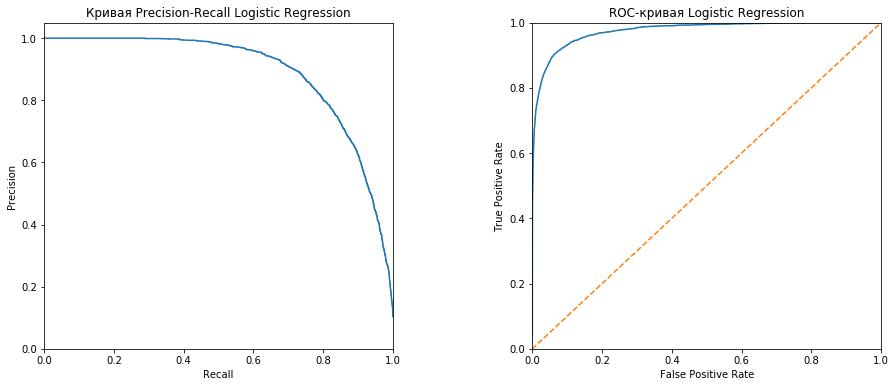

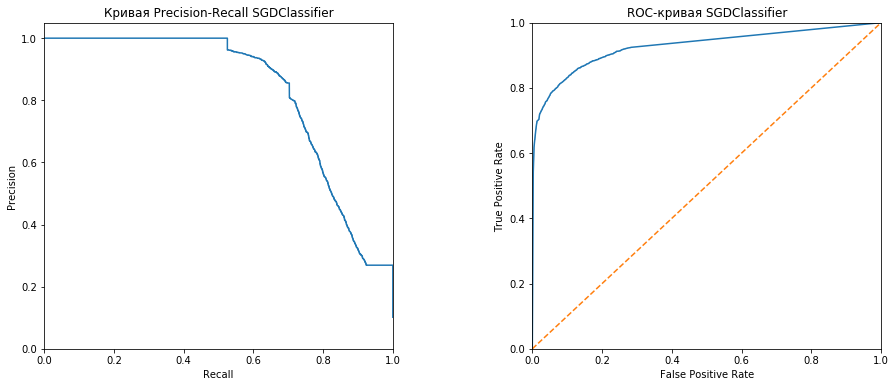

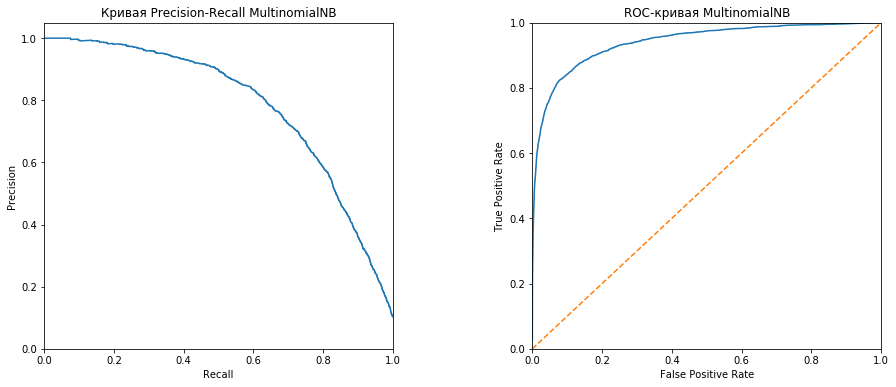

In [17]:
explorer.reporter(models, f1_score, 'f1')

[Оглавление](#TOC)

## Результаты:<a class='anchor' id='2_conclusion'>

**LogisticRegression:**
- F1 Score - 0.80,
- Recall - 0.71,
- Precision - 0.90.

***
**SGDClassifier:**
- F1 Score - 0.77,
- Recall - 0.70,
- Precision - 0.86.

***
**MultinomialNB:**
- F1 Score - 0.66,
- Recall - 0.53,
- Precision - 0.87.


[Оглавление](#TOC)

# 3. Выводы<a class='anchor' id='3'>

#### - выведем на экран целевую метрику и AUC-ROC

In [18]:
explorer.final_report

,model,f1_score,ROC-AUC
0,Logistic Regression,0.796625,0.975153
1,SGDClassifier,0.768761,0.927187
2,MultinomialNB,0.660283,0.940593


1. Лучший результат у логистической регресии, целевая метрика с округлением до тысячных 0.797 (f1), площадь под кривой (ROC-AUC) - 0.98, заметно лучше случайной модели (0.5).
2. Целевая метрика SGDClassifier с округлением до тысячных - 0.769, площадь под кривой (ROC-AUC) - 0.93, худшая из трех моделей.
3. Худший результат у наивного байеса - целевая метрика с округлением до тысячных 0.66 (f1), площадь под кривой (ROC-AUC) - 0.94, также заметно лучше случайной модели (0.5).

[Оглавление](#TOC)